# Run "ETL" script

In [1]:
# Open Spark session 
from pyspark.sql import SparkSession, functions as F


# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("Data_Explorer")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

22/09/07 23:36:25 WARN Utils: Your hostname, James-N580VD-DM229T resolves to a loopback address: 127.0.1.1; using 172.17.238.141 instead (on interface eth0)
22/09/07 23:36:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/07 23:36:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Read the files 
transactions_sample = spark.read.parquet('../data/tables/transactions_20210828_20220227_snapshot')
consumer_details = spark.read.parquet('../data/tables/consumer_user_details.parquet')
merchants_tbl = spark.read.parquet('../data/tables/tbl_merchants.parquet')
customer_tbl = spark.read.option("delimiter", "|").option("header",True).csv('../data/tables/tbl_consumer.csv')

In [4]:
merchants = merchants_tbl.toPandas()

In [5]:
import re
# this function standardises the tags attribute, creating a list with the 'description', 'revenue band' and 'BNPL service charge'
def tag_extract(tag_string): 
    # first need to preprocess
    string =  re.sub('\[','(', tag_string.lower())
    string = re.sub('\]',')', string)
    # break the string into sections
    string_cut = string.split('),')
    new_string = []
    # first extract the description 
    new_string.append(str(string_cut[0].strip('((')))
    # second extract the band
    new_string.append(str(re.search(r'[a-z]',string_cut[1]).group()))
    # finally the take rate
    new_string.append(float(re.search(r'[0-9]+\.[0-9]+',string_cut[2]).group()))
    return(new_string)
################
# now we can run the algorithm
tags = merchants['tags']
processed_tags = []
for i in tags:
    processed_tags.append(tag_extract(i))

In [6]:
import pandas as pd
merchant_tbl = pd.DataFrame(processed_tags, columns=('Description', 'Earnings_Class', 'BNPL_Fee'))
merchant_tbl = pd.concat([merchants, merchant_tbl], axis=1)
# drop the tags column 
merchant_tbl.drop(columns='tags', inplace=True)

In [7]:
# and convert back to spark dataframe 
merchants_tbl = spark.createDataFrame(merchant_tbl)

In [8]:
# This could be further expanded in breaking the discription up further

In [9]:
customer_tbl = customer_tbl.join(consumer_details, ['consumer_id'])

In [10]:
full_dataset = transactions_sample.join(customer_tbl, ['user_id'])
merchants_tbl = merchants_tbl.withColumnRenamed('name','company_name')
full_dataset = full_dataset.join(merchants_tbl, ['merchant_abn'])

In [11]:
# lets add a day (mon,...), weekly & monthly attribute
import pyspark.sql.functions as F
full_dataset = full_dataset.withColumn('Day', F.dayofweek('order_datetime'))
full_dataset = full_dataset.withColumn('Month', F.month('order_datetime'))
# now we can also add the bnpl revenue from a transaction 
full_dataset = full_dataset.withColumn('BNPL_Revenue', F.col('dollar_value') * 0.01 * F.col('BNPL_Fee'))
full_dataset.createOrReplaceTempView('data')
# we can remove name, location and customerID for now, due to being unnnesesary attributes (although company_name could also be removed)
full_dataset = spark.sql("""
select merchant_abn, user_id, dollar_value, order_id, order_datetime, state, postcode, gender, company_name, 
        Description, Earnings_Class, BNPL_Fee, BNPL_Revenue, Day, Month, weekofyear(order_datetime) as weekofyear from data
""")

# Begin week 2 work

In [ ]:
# Compare difference in records between joined table and raw data
full = full_dataset.count()
raw = transactions_sample.count()
print(f'Joined count: {full}, raw count: {raw}, difference {raw - full} or {round(100 * ((raw - full) / raw), 2)}%')
# this is a reduction compared to the 3643266 from records

Joined count: 4323692, raw count: 4508106, difference 184414 or 4.09%


We can see that joining the datasets results in approximately 5% of transaction records being lost

Now lets look if there is any missing data in the dataset

In [ ]:
cols_2 = [f"any({col} is null) as {col}_contains_null" for col in full_dataset.columns]
full_dataset.selectExpr(cols_2).show()

+--------------------------+---------------------+--------------------------+----------------------+----------------------------+-------------------+----------------------+--------------------+--------------------------+-------------------------+----------------------------+----------------------+--------------------------+-----------------+-------------------+------------------------+
|merchant_abn_contains_null|user_id_contains_null|dollar_value_contains_null|order_id_contains_null|order_datetime_contains_null|state_contains_null|postcode_contains_null|gender_contains_null|company_name_contains_null|Description_contains_null|Earnings_Class_contains_null|BNPL_Fee_contains_null|BNPL_Revenue_contains_null|Day_contains_null|Month_contains_null|weekofyear_contains_null|
+--------------------------+---------------------+--------------------------+----------------------+----------------------------+-------------------+----------------------+--------------------+--------------------------+--

From the output there are no null values. However, it is possible that the raw files did contain null values, but were removed in the process of joining the dataset on inner joins (this would explain the drop in approx. 5% of the data). In this case, considering that these records (in particular records which have null merchant_abn, user_id or consumer_id, or correspond to no records) are not collected properly, it is best to not include them in the dataset anyway. Upon examining the raw datasets, they contain no null values, which suggests the drop in records is likely due to incorrect keys being used (e.g. a unregistered abn number being used)

# Outlier analysis 

In [ ]:
gl = full_dataset.toPandas()

In [ ]:
# Lets aritraray remove values below $10 and over 1000 dollars to get a better look at the 'normal' distribution of transactions
gl_plot = gl[(gl['dollar_value'] > 10) & (gl['dollar_value'] < 1000)]

<AxesSubplot:xlabel='Earnings_Class', ylabel='dollar_value'>

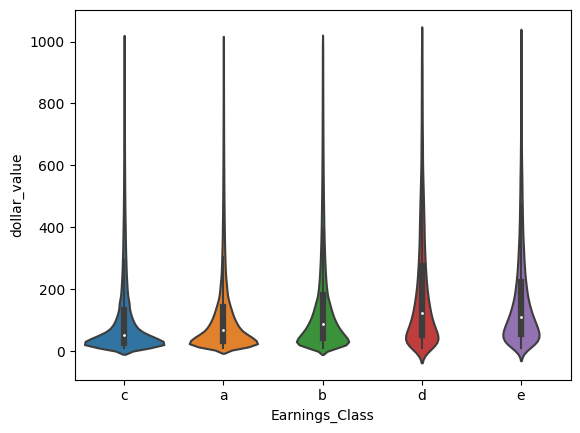

In [ ]:
import seaborn as sns
sns.violinplot(x='Earnings_Class',y='dollar_value', data=gl_plot)

We can see, as specified, that the average dollar_value for each earning_band does appear to follow the described order in the readme files. However, considering the large maximums they all share, a 'cap' should be used to removed outliers from our dataset, to ensure 'consistently performing companies' are ranked higher than 'one off' ones.  

The rest is from week 1

In [21]:
# now we can perform aggregation
full_dataset.createOrReplaceTempView('las')
top_100 = spark.sql("""
select company_name, sum(BNPL_Revenue) as BNPL_Revenue, Earnings_Class from las
group by company_name, Earnings_Class
order by BNPL_Revenue desc
limit 10
""")
top_100.createOrReplaceTempView('las1')
agg_data = spark.sql("""
select sum(BNPL_Revenue) as revenue, order_datetime, company_name, Earnings_Class from las
group by order_datetime, company_name, Earnings_Class
having company_name in (select company_name from las1)""")
# don't care about the top 50
agg_data2 = spark.sql("""
select sum(BNPL_Revenue) as revenue, company_name, Earnings_Class from las
group by company_name, Earnings_Class
""")

In [22]:
agg_data = agg_data.toPandas()
agg_data2 = agg_data2.toPandas()

[Text(0.5, 1.0, 'Comparison of Top 10 BNPL Revenue companies over time')]

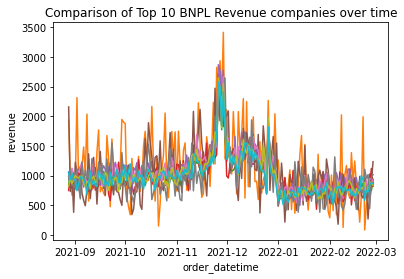

In [23]:
# This plot is to just examine the revenue over time of the top 'ranked' companies
import seaborn as sns
# can switch hue to Earnings_Class to see that a & b dominate top 10
g = sns.lineplot(x = 'order_datetime', y = 'revenue', hue = 'company_name', data=agg_data, legend=False)
g.set(title='Comparison of Top 10 BNPL Revenue companies over time')
# we can see that these is a visible gab between each company, but further analysis would be good 

<AxesSubplot:xlabel='Earnings_Class', ylabel='revenue'>

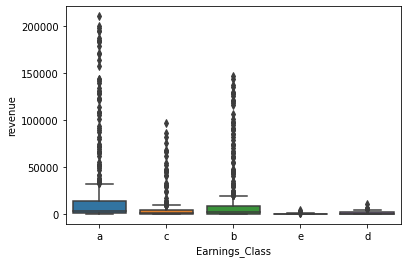

In [24]:
# Lets look at the distribution of total revenue of each company, and colured by revenue band
sns.boxplot(y='revenue', x='Earnings_Class', data=agg_data2)
# we can see that the all data is heavily left skewed??, with there visible 'outliers' for each revenue band. 
# taking the metric alone, a classed companies appear to produce the most BNPL money, but again when we start factoring in other 
# important measures, then we will have a better understanding.

In [25]:
# Lets look at the total BNPL revenue from the whole timeline
earnings_distribution = spark.sql("""select Earnings_Class, sum(BNPL_Revenue) as BNPL_Revenue from las group by Earnings_Class""")
transaction_distribution = spark.sql("""select Earnings_Class, count(*) as Prop from las group by Earnings_Class""")

In [26]:
earnings_distribution = earnings_distribution.toPandas()
transaction_distribution = transaction_distribution.toPandas()
# standardize the frequencies
divide = full_dataset.count()
transaction_distribution['Prop'] = transaction_distribution['Prop'] / divide

[Text(0.5, 1.0, 'Distribution of BNPL Revenue by company Class')]

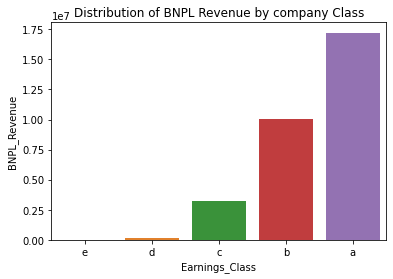

In [27]:
# Lets look at the makeup of BNPL revenue by their Earnings band 
sns.barplot(x='Earnings_Class', y= 'BNPL_Revenue', data = earnings_distribution).set(title='Distribution of BNPL Revenue by company Class')

[Text(0.5, 1.0, 'Proportion of customer demand by earning class')]

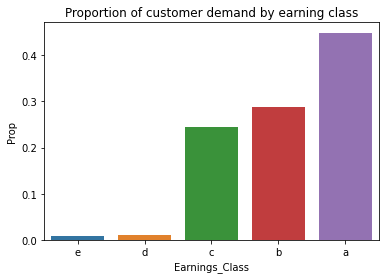

In [28]:
# Lets look at the makeup of BNPL revenue by their Earnings band 
sns.barplot(x='Earnings_Class',y= 'Prop',data = transaction_distribution).set(title='Proportion of customer demand by earning class')